In [9]:
!pip install scikit-plot

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from collections import defaultdict
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# Data preparation

In [10]:
from google.colab import files
uploaded = files.upload()
df = uploaded
df = pd.read_csv('air_dataset.csv')
df.drop(columns='Unnamed: 0',inplace=True)
class_name = 'weekend'
df.head()

Saving air_dataset.csv to air_dataset.csv


,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


In [11]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    df = df.reindex(dfX.index)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [12]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [13]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,PT08_feat,weekend
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,1186.50,0
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,1148.75,0
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,1024.50,0
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,1015.00,0
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,883.25,0


# Data partitioning

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score

In [15]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

# Random forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
import pickle
pickle.dump(clf, 'filename.pickle')
clf = pickle.load('filename.pickle')

TypeError: ignored

In [55]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7751068376068376
Precision 0.6881028938906752
Recall 0.39776951672862454
F1-score 0.6793496768523775
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      1334
           1       0.69      0.40      0.50       538

    accuracy                           0.78      1872
   macro avg       0.74      0.66      0.68      1872
weighted avg       0.76      0.78      0.75      1872



array([[1237,   97],
       [ 324,  214]])

In [56]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'f1-score': 0.8545768566493955,
  'precision': 0.7924407431133889,
  'recall': 0.9272863568215892,
  'support': 1334},
 '1': {'f1-score': 0.5041224970553593,
  'precision': 0.6881028938906752,
  'recall': 0.39776951672862454,
  'support': 538},
 'accuracy': 0.7751068376068376,
 'macro avg': {'f1-score': 0.6793496768523775,
  'precision': 0.740271818502032,
  'recall': 0.6625279367751069,
  'support': 1872},
 'weighted avg': {'f1-score': 0.753858669971195,
  'precision': 0.7624547586679722,
  'recall': 0.7751068376068376,
  'support': 1872}}

In [57]:
y_test

694     0
6036    0
8287    0
3627    0
5637    0
       ..
562     0
8589    0
4875    1
5954    1
203     0
Name: weekend, Length: 1872, dtype: int64

In [58]:
import json
json.dumps(classification_report(y_test, y_pred, output_dict=True))

'{"0": {"precision": 0.7924407431133889, "recall": 0.9272863568215892, "f1-score": 0.8545768566493955, "support": 1334}, "1": {"precision": 0.6881028938906752, "recall": 0.39776951672862454, "f1-score": 0.5041224970553593, "support": 538}, "accuracy": 0.7751068376068376, "macro avg": {"precision": 0.740271818502032, "recall": 0.6625279367751069, "f1-score": 0.6793496768523775, "support": 1872}, "weighted avg": {"precision": 0.7624547586679722, "recall": 0.7751068376068376, "f1-score": 0.753858669971195, "support": 1872}}'

In [59]:
json.loads(json.dumps(classification_report(y_test, y_pred, output_dict=True)))

{'0': {'f1-score': 0.8545768566493955,
  'precision': 0.7924407431133889,
  'recall': 0.9272863568215892,
  'support': 1334},
 '1': {'f1-score': 0.5041224970553593,
  'precision': 0.6881028938906752,
  'recall': 0.39776951672862454,
  'support': 538},
 'accuracy': 0.7751068376068376,
 'macro avg': {'f1-score': 0.6793496768523775,
  'precision': 0.740271818502032,
  'recall': 0.6625279367751069,
  'support': 1872},
 'weighted avg': {'f1-score': 0.753858669971195,
  'precision': 0.7624547586679722,
  'recall': 0.7751068376068376,
  'support': 1872}}

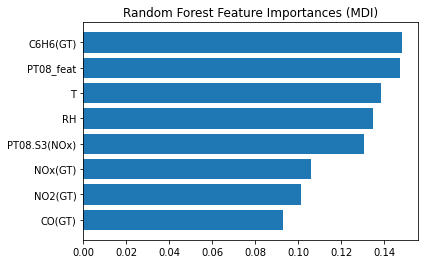

In [60]:
nbr_features = int(df.shape[1]) - 1

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(feature_names)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.savefig('bohnonso.png')
plt.show()

In [61]:
from sklearn.inspection import permutation_importance

In [22]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

In [24]:
result

{'importances': array([[0.03952991, 0.05395299, 0.04487179, 0.03365385, 0.02564103,
         0.04594017, 0.0582265 , 0.02617521, 0.03365385, 0.03472222],
        [0.10470085, 0.09615385, 0.09935897, 0.10790598, 0.09294872,
         0.09668803, 0.09081197, 0.09989316, 0.08653846, 0.09081197],
        [0.01762821, 0.02136752, 0.02457265, 0.03739316, 0.02884615,
         0.02724359, 0.01495726, 0.02991453, 0.0224359 , 0.01495726],
        [0.03952991, 0.02938034, 0.04273504, 0.03685897, 0.04220085,
         0.02617521, 0.04326923, 0.02724359, 0.03098291, 0.03151709],
        [0.01495726, 0.00961538, 0.01816239, 0.01869658, 0.01869658,
         0.01495726, 0.01709402, 0.01655983, 0.01282051, 0.01655983],
        [0.04594017, 0.02724359, 0.02884615, 0.04380342, 0.03632479,
         0.0400641 , 0.03205128, 0.04540598, 0.03952991, 0.03525641],
        [0.03044872, 0.02724359, 0.02029915, 0.02403846, 0.0267094 ,
         0.02991453, 0.02564103, 0.01923077, 0.01602564, 0.02190171],
        [0.0

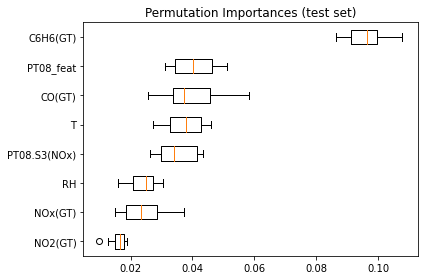

In [23]:
sorted_idx = result.importances_mean.argsort()[-nbr_features:]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [ ]:
dfimport pydotplus
from sklearn import tree
from IPython.display import Image

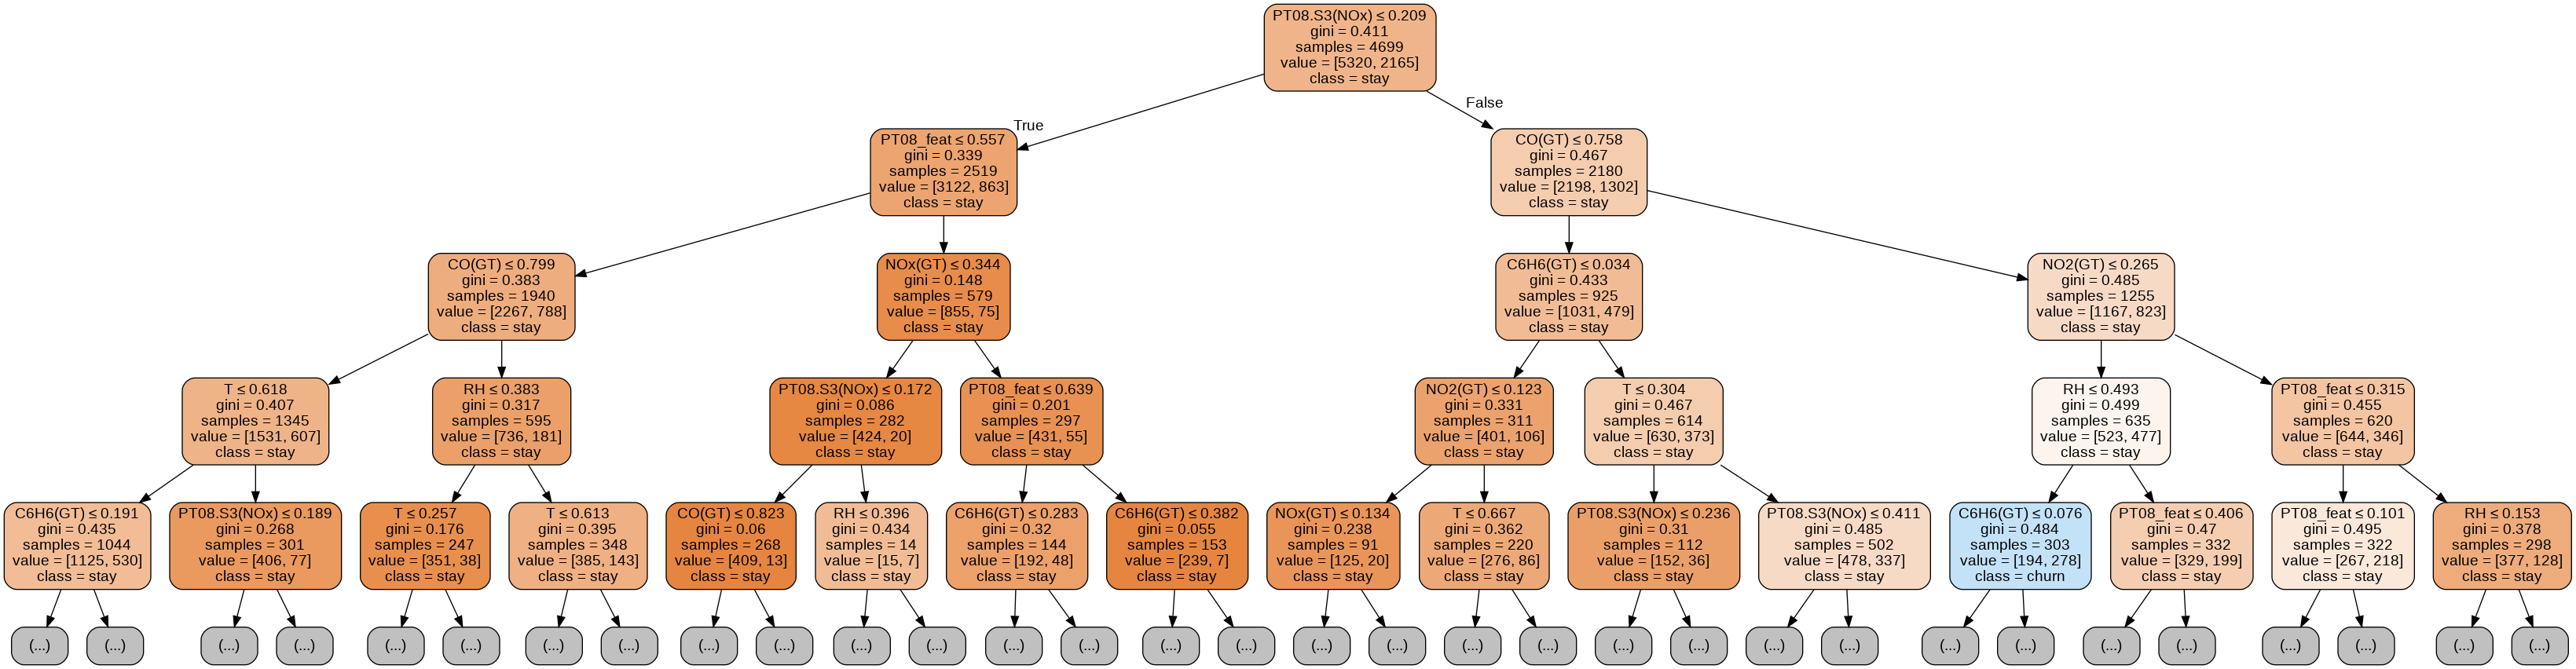

In [ ]:
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['stay', 'churn'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [ ]:
clf.estimators_

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=4, max_features='log2', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=209652396, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=4, max_features='log2', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=398764591, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=4, max_feature

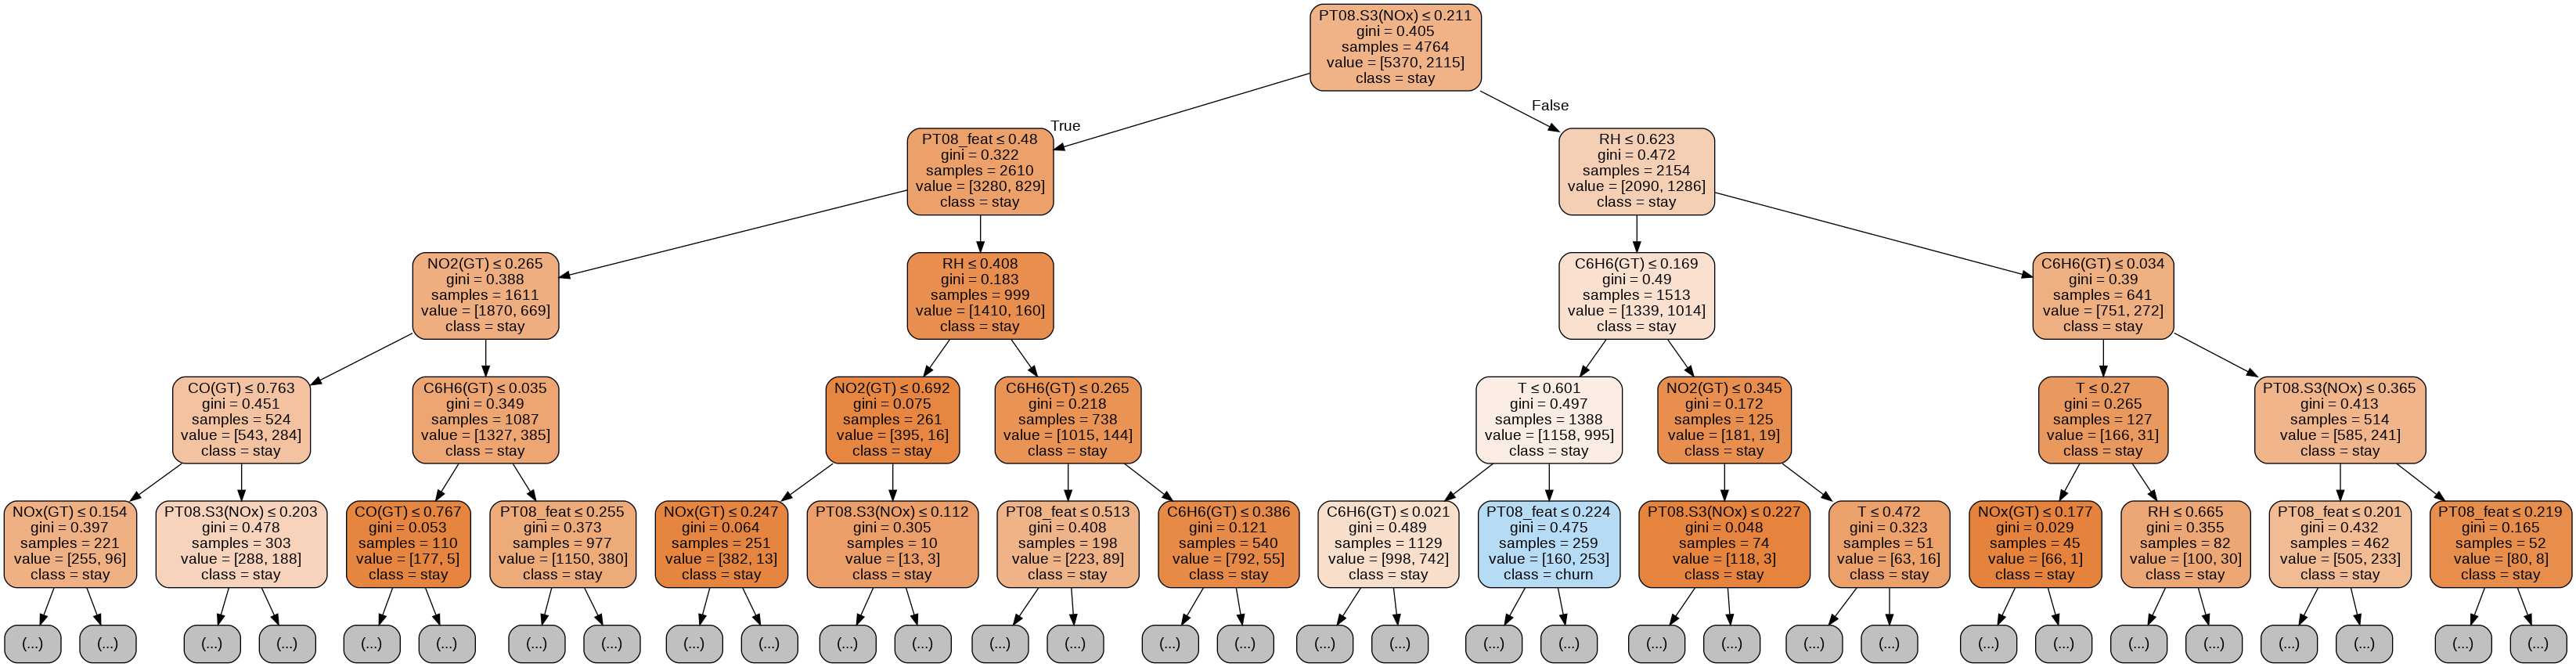

In [ ]:
dot_data = tree.export_graphviz(clf.estimators_[1], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['stay', 'churn'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=4, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7825854700854701
Precision 0.6876790830945558
Recall 0.44609665427509293
F1-score 0.6993464103870357
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1334
           1       0.69      0.45      0.54       538

    accuracy                           0.78      1872
   macro avg       0.75      0.68      0.70      1872
weighted avg       0.77      0.78      0.77      1872



array([[1225,  109],
       [ 298,  240]])

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.780982905982906
Precision 0.686046511627907
Recall 0.43866171003717475
F1-score 0.6959454641395343
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1334
           1       0.69      0.44      0.54       538

    accuracy                           0.78      1872
   macro avg       0.74      0.68      0.70      1872
weighted avg       0.77      0.78      0.76      1872



array([[1226,  108],
       [ 302,  236]])

In [63]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7783119658119658
Precision 0.6858006042296072
Recall 0.42193308550185876
F1-score 0.6890458798218841
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1334
           1       0.69      0.42      0.52       538

    accuracy                           0.78      1872
   macro avg       0.74      0.67      0.69      1872
weighted avg       0.77      0.78      0.76      1872



array([[1230,  104],
       [ 311,  227]])

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.718482905982906
Precision 1.0
Recall 0.020446096654275093
F1-score 0.43756381641396647
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1334
           1       1.00      0.02      0.04       538

    accuracy                           0.72      1872
   macro avg       0.86      0.51      0.44      1872
weighted avg       0.80      0.72      0.61      1872



array([[1334,    0],
       [ 527,   11]])

### Cross Validation

In [25]:
from sklearn.model_selection import cross_val_score


In [26]:
clf = RandomForestClassifier()
scores = cross_val_score(clf, X, y, cv=5)

print('Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Accuracy 0.710 +/- 0.024


### Tuning the hyper-parameters

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [28]:
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
             }

grid_search = GridSearchCV(clf, param_grid=param_list, cv=5)
grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7745726495726496
Precision 0.6757575757575758
Recall 0.4144981412639405
F1-score 0.6835466565826833
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1334
           1       0.68      0.41      0.51       538

    accuracy                           0.77      1872
   macro avg       0.74      0.67      0.68      1872
weighted avg       0.76      0.77      0.76      1872



array([[1227,  107],
       [ 315,  223]])

In [29]:
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
             }

grid_search = GridSearchCV(clf, param_grid=param_list, cv=5, scoring = 'f1_macro')
grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7767094017094017
Precision 0.7
Recall 0.3903345724907063
F1-score 0.6786764935357181
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      1334
           1       0.70      0.39      0.50       538

    accuracy                           0.78      1872
   macro avg       0.75      0.66      0.68      1872
weighted avg       0.77      0.78      0.75      1872



array([[1244,   90],
       [ 328,  210]])

In [30]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc

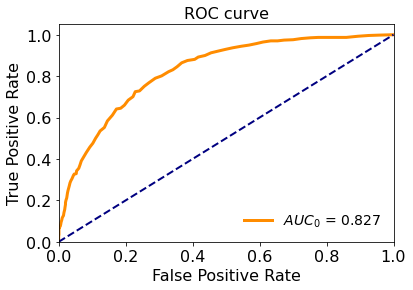

In [31]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [32]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=5)
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

print(random_search.best_estimator_)


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy 0.7622863247863247
Precision 0.6867469879518072
Recall 0.31784386617100374
F1-score 0.6420356322881247
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1334
           1       0.69      0.32      0.43       538

    accuracy                           0.76      1872
   macro avg       0.73      0.63      0.64      1872
weighted avg       0.75      0.76      0.73      1872



array([[1256,   78],
       [ 367,  171]])

In [33]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=5, scoring = 'recall')
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

print(random_search.best_estimator_)


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy 0.7735042735042735
Precision 0.7298387096774194
Recall 0.33643122676579923
F1-score 0.6586098508895529
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1334
           1       0.73      0.34      0.46       538

    accuracy                           0.77      1872
   macro avg       0.76      0.64      0.66      1872
weighted avg       0.77      0.77      0.74      1872



array([[1267,   67],
       [ 357,  181]])

In [40]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=5, scoring = 'accuracy')
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

print(random_search.best_estimator_)


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=19, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy 0.7574786324786325
Precision 0.6858407079646017
Recall 0.28810408921933084
F1-score 0.6267050845075371
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1334
           1       0.69      0.29      0.41       538

    accuracy                           0.76      1872
   macro avg       0.73      0.62      0.63      1872
weighted avg       0.74      0.76      0.72      1872



array([[1263,   71],
       [ 383,  155]])

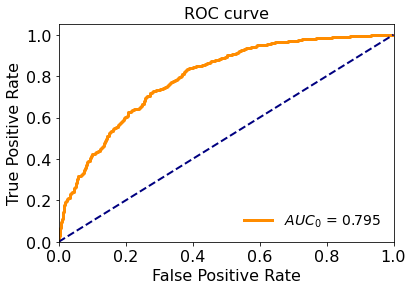

In [41]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [42]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=5, scoring = 'roc_auc')
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

print(random_search.best_estimator_)


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy 0.7467948717948718
Precision 0.7461538461538462
Recall 0.18029739776951673
F1-score 0.5681614664039931
              precision    recall  f1-score   support

           0       0.75      0.98      0.85      1334
           1       0.75      0.18      0.29       538

    accuracy                           0.75      1872
   macro avg       0.75      0.58      0.57      1872
weighted avg       0.75      0.75      0.69      1872



array([[1301,   33],
       [ 441,   97]])

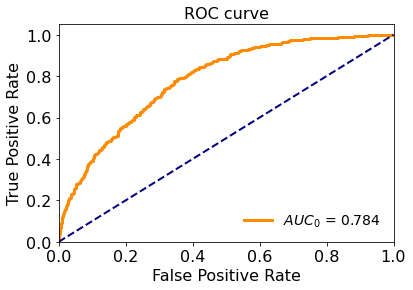

In [43]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [44]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=5, scoring = 'f1_macro')
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

print(random_search.best_estimator_)


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=19, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy 0.7692307692307693
Precision 0.6879432624113475
Recall 0.36059479553903345
F1-score 0.6627139568249307
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1334
           1       0.69      0.36      0.47       538

    accuracy                           0.77      1872
   macro avg       0.74      0.65      0.66      1872
weighted avg       0.76      0.77      0.74      1872



array([[1246,   88],
       [ 344,  194]])

In [37]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

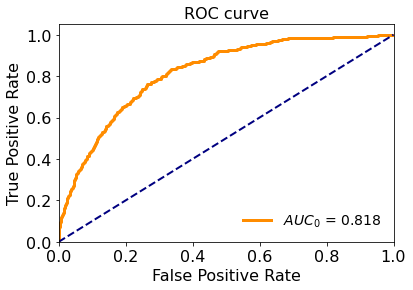

In [45]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [38]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=5, scoring = 'precision')
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

print(random_search.best_estimator_)


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy 0.7232905982905983
Precision 0.8125
Recall 0.048327137546468404
F1-score 0.4640135309919411
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1334
           1       0.81      0.05      0.09       538

    accuracy                           0.72      1872
   macro avg       0.77      0.52      0.46      1872
weighted avg       0.75      0.72      0.62      1872



array([[1328,    6],
       [ 512,   26]])

In [39]:
random_search.cv_results_['params'][random_search.cv_results_['rank_test_score'][0]]

{'max_depth': 18,
 'max_features': 'auto',
 'min_samples_leaf': 20,
 'min_samples_split': 20}

# Bagging

In [19]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [28]:
from sklearn.naive_bayes import GaussianNB

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

If None, then the base estimator is a decision tree.


In [39]:
clf = BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.01, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7206196581196581
Precision 0.5619834710743802
Recall 0.12639405204460966
F1-score 0.5184216545377186
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1334
           1       0.56      0.13      0.21       538

    accuracy                           0.72      1872
   macro avg       0.65      0.54      0.52      1872
weighted avg       0.68      0.72      0.65      1872



array([[1281,   53],
       [ 470,   68]])

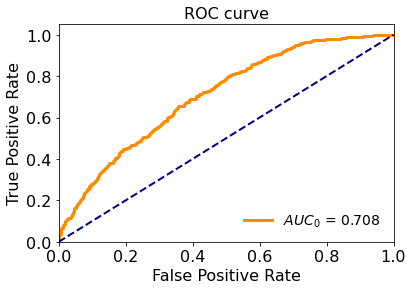

In [40]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [32]:
clf = BaggingClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7761752136752137
Precision 0.6595174262734584
Recall 0.45724907063197023
F1-score 0.6960830543891714
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1334
           1       0.66      0.46      0.54       538

    accuracy                           0.78      1872
   macro avg       0.73      0.68      0.70      1872
weighted avg       0.76      0.78      0.76      1872



array([[1207,  127],
       [ 292,  246]])

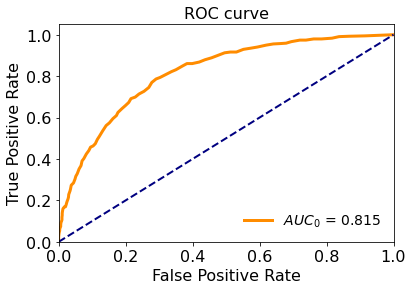

In [33]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [25]:
clf = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=9, weights='distance'), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7302350427350427
Precision 0.5447154471544715
Recall 0.3736059479553903
F1-score 0.6326072349201894
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1334
           1       0.54      0.37      0.44       538

    accuracy                           0.73      1872
   macro avg       0.66      0.62      0.63      1872
weighted avg       0.71      0.73      0.71      1872



array([[1166,  168],
       [ 337,  201]])

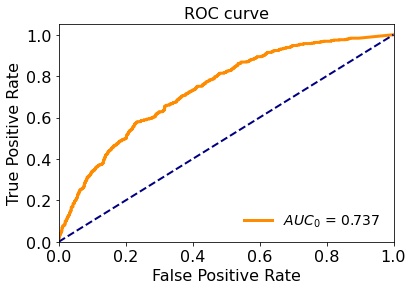

In [26]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [30]:
clf = BaggingClassifier(base_estimator=GaussianNB(), n_estimators=100, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.5774572649572649
Precision 0.37462834489593655
Recall 0.7026022304832714
F1-score 0.5643256847572894
              precision    recall  f1-score   support

           0       0.81      0.53      0.64      1334
           1       0.37      0.70      0.49       538

    accuracy                           0.58      1872
   macro avg       0.59      0.61      0.56      1872
weighted avg       0.69      0.58      0.60      1872



array([[703, 631],
       [160, 378]])

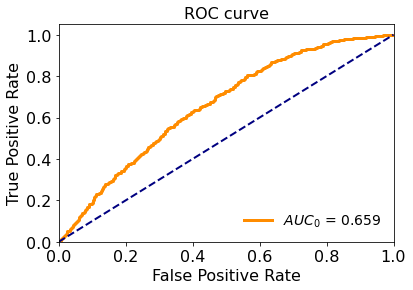

In [31]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [49]:
clf = BaggingClassifier(base_estimator=SVC(C=0.1), n_estimators=10, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7126068376068376
Precision 0.0
Recall 0.0
F1-score 0.4160948222083593
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1334
           1       0.00      0.00      0.00       538

    accuracy                           0.71      1872
   macro avg       0.36      0.50      0.42      1872
weighted avg       0.51      0.71      0.59      1872



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1334,    0],
       [ 538,    0]])

In [37]:
clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100,max_depth = 19, max_features = 'auto', min_samples_split= 10, min_samples_leaf=1), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7649572649572649
Precision 0.71875
Recall 0.2992565055762082
F1-score 0.6375100999698982
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1334
           1       0.72      0.30      0.42       538

    accuracy                           0.76      1872
   macro avg       0.74      0.63      0.64      1872
weighted avg       0.76      0.76      0.73      1872



array([[1271,   63],
       [ 377,  161]])

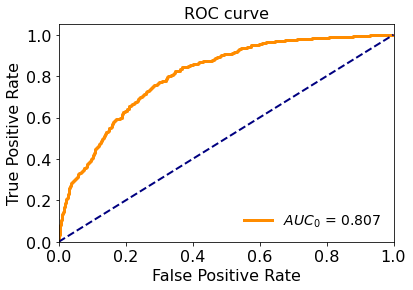

In [35]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Boosting

In [43]:
from sklearn.ensemble import AdaBoostClassifier

If None, then the base estimator is DecisionTreeClassifier(max_depth=1).

In [49]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7035256410256411
Precision 0.4514285714285714
Recall 0.14684014869888476
F1-score 0.5192454963969788
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      1334
           1       0.45      0.15      0.22       538

    accuracy                           0.70      1872
   macro avg       0.59      0.54      0.52      1872
weighted avg       0.65      0.70      0.65      1872



array([[1238,   96],
       [ 459,   79]])

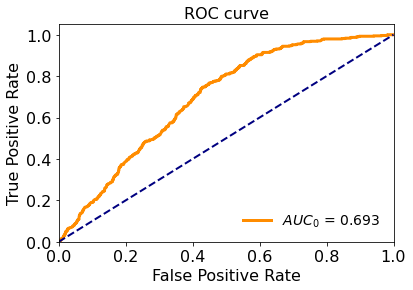

In [45]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [47]:
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7756410256410257
Precision 0.684375
Recall 0.4070631970260223
F1-score 0.6824796824796824
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1334
           1       0.68      0.41      0.51       538

    accuracy                           0.78      1872
   macro avg       0.74      0.67      0.68      1872
weighted avg       0.76      0.78      0.76      1872



array([[1233,  101],
       [ 319,  219]])

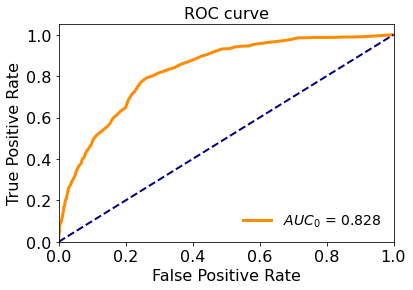

In [48]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [51]:
clf = AdaBoostClassifier(base_estimator=GaussianNB(), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm




Accuracy 0.405982905982906
Precision 0.3042291950886767
Recall 0.828996282527881
F1-score 0.40301466033450345
              precision    recall  f1-score   support

           0       0.77      0.24      0.36      1334
           1       0.30      0.83      0.45       538

    accuracy                           0.41      1872
   macro avg       0.54      0.53      0.40      1872
weighted avg       0.64      0.41      0.39      1872



array([[ 314, 1020],
       [  92,  446]])

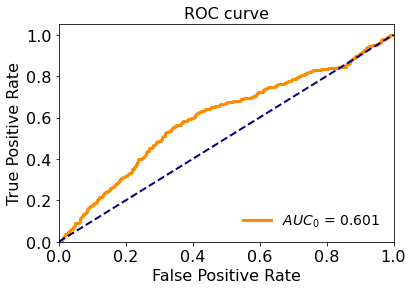

In [52]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [53]:
clf = AdaBoostClassifier(MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.01, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm


ValueError: ignored